In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC

%matplotlib inline


In [23]:
data = pd.read_csv('epi_r.csv')

In [3]:
data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data.shape

(20052, 680)

In [6]:
data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

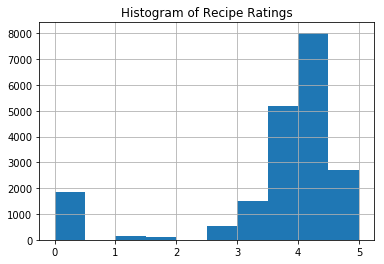

In [8]:
data.rating.hist()
plt.title('Histogram of Recipe Ratings')
plt.show()

In [9]:
# Count nulls 
null_count = data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [ ]:
from sklearn.svm import SVR
svr = SVR()
X = data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = data.rating
svr.fit(X,Y)

In [14]:
X.shape

(20052, 674)

# Challenge

To Turn this into a classification problem , change the ratings as 1 and 0 instead of a continuous variable.

In [24]:
X = data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = data.rating
X = pd.get_dummies(X)
Y = data['rating'].apply(lambda x: 1 if x >= 3.5 else 0)

In [16]:
X.shape

(20052, 674)

# Narrow down the features list by using most important features from random forest model 

In [25]:

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()


In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [27]:
df = pd.DataFrame()
df['imp']= rfc.fit(X_train, Y_train).feature_importances_
df['features'] = X_train.columns
df2 = df.sort_values(by='imp', ascending=False)
important_features = df2['features'].iloc[0:30].tolist()
print(important_features)

['bon appétit', 'gourmet', 'quick & easy', 'summer', 'fall', 'vegetarian', 'wheat/gluten-free', 'vegetable', 'drink', 'healthy', 'winter', 'bake', 'kid-friendly', 'alcoholic', 'house & garden', 'milk/cream', 'cocktail', 'dairy', 'spring', 'egg', 'tomato', 'kidney friendly', 'onion', 'lemon', 'side', 'garlic', 'dessert', 'vegan', 'dinner', 'herb']


In [28]:
imp_feat_df = X_train.loc[:,(X_train.columns).isin(important_features)]

In [29]:
imp_feat_df.shape

(15039, 30)

In [30]:
#Apply SVC to classify 

svc = SVC()
X_train_imp_feat = imp_feat_df

svc.fit(X_train_imp_feat,Y_train)
score = cross_val_score(svc, X_train_imp_feat, Y_train, cv=10)
print('Accuracy :')
print(score)
print('\nAverage Accuracy :')
print(score.mean())

Accuracy :
[ 0.80265781  0.80199336  0.80598007  0.79654255  0.80452128  0.79654255
  0.79640719  0.80239521  0.8003992   0.79973387]

Average Accuracy :
0.800717307462


# Try to narrow down the features list by using PCA on standardised data

In [31]:
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_std)

X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.25)

svc.fit(X_train,Y_train)
score = cross_val_score(svc, X_train, Y_train, cv=10)
print('Accuracy :')
print(score)
print('\nAverage Accuracy :')
print(score.mean())

Accuracy :
[ 0.80984043  0.80518617  0.81582447  0.80984043  0.80053191  0.81582447
  0.80917553  0.80385638  0.8125      0.81104458]

Average Accuracy :
0.809362436475


# Try to narrow Features based on Common Ingredients

In [11]:
#identifying the top most used ingredients 
ingred_count = pd.DataFrame(data.drop(['title', 'rating', 'calories', 'protein', 'fat', 'sodium'], 1).sum(), columns=['count'])

top_ingred_count = ingred_count.sort_values(by='count', ascending=False).head(30)
top_ingred = list(top_ingred_count.index)

X1 = data[top_ingred]
Y = data['rating'].apply(lambda x: 1 if x >= 3.5 else 0)

In [12]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y, test_size=0.25)

In [19]:
svc = SVC() 
svc.fit(X1_train,Y1_train)
score = cross_val_score(svc, X1_train,Y1_train, cv=10)
print('Accuracy :')
print(score)
print('\nAverage Accuracy :')
print(score.mean())

Accuracy :
[ 0.79388298  0.79388298  0.79388298  0.79388298  0.79388298  0.79388298
  0.79388298  0.79388298  0.79388298  0.79441118]

Average Accuracy :
0.793935798616


In [32]:
score = cross_val_score(svc, X1_test,Y1_test, cv=10)
print('Accuracy :')
print(score)
print('\nAverage Accuracy :')
print(score.mean())

Accuracy :
[ 0.79083665  0.79083665  0.79083665  0.79083665  0.79083665  0.79083665
  0.79241517  0.792       0.792       0.792     ]

Average Accuracy :
0.791343508998


# Bias

In [64]:
data['rating_cat'] = data['rating'].apply(lambda x: 'Good' if x >= 3.5 else 'Bad')
data.rating_cat.value_counts()

Good    15907
Bad      4145
Name: rating_cat, dtype: int64

In [46]:
data[ data['3-ingredient recipes'] != 0.0].shape

(27, 680)

In [65]:
 data.groupby(['rating_cat','3-ingredient recipes'])['rating'].count()

rating_cat  3-ingredient recipes
Bad         0.0                      4128
            1.0                        17
Good        0.0                     15897
            1.0                        10
Name: rating, dtype: int64

In [66]:
 data.groupby(['rating_cat','chocolate'])['rating'].count()

rating_cat  chocolate
Bad         0.0           3983
            1.0            162
Good        0.0          15214
            1.0            693
Name: rating, dtype: int64

In [67]:
data.groupby(['rating_cat','christmas'])['rating'].count()

rating_cat  christmas
Bad         0.0           3983
            1.0            162
Good        0.0          15030
            1.0            877
Name: rating, dtype: int64

In [68]:
data.groupby(['rating_cat','dairy free'])['rating'].count()

rating_cat  dairy free
Bad         0.0            3494
            1.0             651
Good        0.0           13352
            1.0            2555
Name: rating, dtype: int64

In [69]:
data.groupby(['rating_cat','deep-fry'])['rating'].count()

rating_cat  deep-fry
Bad         0.0          4118
            1.0            27
Good        0.0         15842
            1.0            65
Name: rating, dtype: int64

In [70]:
data.groupby(['rating_cat','fat free'])['rating'].count()

rating_cat  fat free
Bad         0.0          4052
            1.0            93
Good        0.0         15624
            1.0           283
Name: rating, dtype: int64

Fat Free foods got higher good reviews.  people more likely to choose some kinds of recipes like Fat-free, deep-fry, dairy-free etc are more likely to give high reviews.